In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import torch
from rlaopt.solvers import PCGConfig, SAPConfig, SAPAccelConfig
from rlaopt.preconditioners import NystromConfig
from rlaopt.kernels import KernelConfig
from scalable_gp_inference.bayes_opt.configs import BayesOptConfig, TSConfig
from scalable_gp_inference.bayes_opt.core import BayesOpt


In [3]:
device = torch.device("cuda:1")
dtype = torch.float32
seed = 4

noise_variance = 1e-6
lengthscale = 0.5
pcg_iters = 10
num_blocks = 5
kernel_type = "matern32"
n_steps = 2

In [4]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)

In [5]:
kernel_config = KernelConfig(const_scaling=1.0, lengthscale=lengthscale)

In [6]:
precond_config = NystromConfig(rank=100, rho=noise_variance)

In [7]:
bayes_config = BayesOptConfig(kernel_config=kernel_config, kernel_type=kernel_type, noise_variance=noise_variance)

In [8]:
ts_config = TSConfig()

In [9]:
opt = BayesOpt(bayes_config, device=device, dtype=dtype)

In [10]:
opt.bo_state

BayesOptState(X=tensor([[0.1324, 0.9975, 0.9055,  ..., 0.0950, 0.1201, 0.0398],
        [0.0035, 0.6365, 0.7550,  ..., 0.3010, 0.7070, 0.9050],
        [0.3070, 0.6371, 0.7869,  ..., 0.7716, 0.4719, 0.6068],
        ...,
        [0.5992, 0.3048, 0.3650,  ..., 0.2779, 0.1351, 0.2537],
        [0.5670, 0.4210, 0.4183,  ..., 0.2964, 0.3108, 0.8408],
        [0.3181, 0.9759, 0.9053,  ..., 0.2570, 0.2531, 0.5466]],
       device='cuda:1'), y=tensor([ 2.7331,  0.3682,  1.2351,  ..., -0.4443,  0.6552,  0.6054],
       device='cuda:1'), rf_obj=<scalable_gp_inference.random_features.RandomFeatures object at 0x7f8ef02e0d60>, w_true=tensor([-0.2938,  0.7819, -1.4731,  ..., -0.6513,  1.7750, -0.8584],
       device='cuda:1'), fn_max=3.9183528423309326, fn_argmax=27273)

In [11]:
for _ in range(n_steps):
    solver_config = PCGConfig(device=device, max_iters=pcg_iters,
                              precond_config=precond_config, atol=1e-12, rtol=1e-12)
    # solver_config = SAPConfig(device=device, max_iters=pcg_iters * num_blocks, atol=1e-12, rtol=1e-12, 
    #                           precond_config=precond_config, blk_sz=len(opt.bo_state) // num_blocks,
    #                           accel=True, accel_config=SAPAccelConfig(mu=noise_variance, nu=num_blocks*1.0))
    opt.step(ts_config, solver_config)

In [12]:
opt.bo_state

BayesOptState(X=tensor([[0.1324, 0.9975, 0.9055,  ..., 0.0950, 0.1201, 0.0398],
        [0.0035, 0.6365, 0.7550,  ..., 0.3010, 0.7070, 0.9050],
        [0.3070, 0.6371, 0.7869,  ..., 0.7716, 0.4719, 0.6068],
        ...,
        [0.9995, 0.0075, 0.5988,  ..., 0.9943, 0.9967, 0.9022],
        [0.4729, 0.0354, 0.7793,  ..., 0.1981, 1.0000, 0.3750],
        [0.0943, 0.9602, 0.0639,  ..., 0.3269, 0.9766, 0.7273]],
       device='cuda:1'), y=tensor([2.7331, 0.3682, 1.2351,  ..., 2.7706, 1.1118, 1.2367], device='cuda:1'), rf_obj=<scalable_gp_inference.random_features.RandomFeatures object at 0x7f8ef02e0d60>, w_true=tensor([-0.2938,  0.7819, -1.4731,  ..., -0.6513,  1.7750, -0.8584],
       device='cuda:1'), fn_max=3.9183528423309326, fn_argmax=27273)

In [13]:
len(opt.bo_state)

52000

(array([ 1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,
         0.,  4.,  3.,  1.,  5.,  7., 12.,  5.,  8., 10., 12., 11., 10.,
        15., 12., 20., 23., 28., 23., 23., 29., 29., 27., 29., 44., 29.,
        39., 52., 35., 48., 55., 62., 38., 53., 69., 41., 50., 57., 46.,
        56., 47., 55., 55., 52., 52., 41., 46., 42., 39., 55., 26., 37.,
        26., 25., 22., 22., 17., 19., 26., 17.,  9., 10., 12., 14., 22.,
        14.,  9.,  4.,  5., 14.,  7.,  3.,  2.,  5.,  3.,  5.,  1.,  3.,
         1.,  2.,  2.,  0.,  1.,  1.,  0.,  1.,  1.]),
 array([-2.96988225e+00, -2.90243864e+00, -2.83499479e+00, -2.76755118e+00,
        -2.70010734e+00, -2.63266373e+00, -2.56521988e+00, -2.49777627e+00,
        -2.43033266e+00, -2.36288881e+00, -2.29544497e+00, -2.22800136e+00,
        -2.16055775e+00, -2.09311390e+00, -2.02567029e+00, -1.95822656e+00,
        -1.89078283e+00, -1.82333910e+00, -1.75589538e+00, -1.68845165e+00,
        -1.62100792e+00, -1.55356431e+00, -1.48612058e

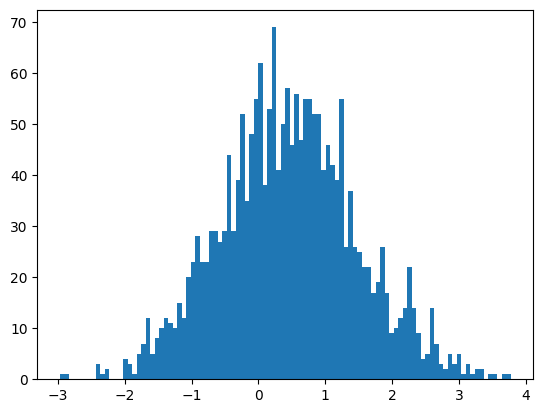

In [14]:
import matplotlib.pyplot as plt

plt.hist(opt.bo_state.y[50000:].cpu().numpy(), bins=100)

(array([2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 3.000e+00, 7.000e+00, 7.000e+00, 8.000e+00, 5.000e+00,
        1.400e+01, 2.200e+01, 3.100e+01, 4.000e+01, 3.800e+01, 5.100e+01,
        7.200e+01, 8.400e+01, 1.170e+02, 1.240e+02, 1.460e+02, 1.830e+02,
        2.480e+02, 2.760e+02, 3.430e+02, 3.700e+02, 4.600e+02, 5.050e+02,
        5.660e+02, 6.820e+02, 7.010e+02, 8.500e+02, 8.960e+02, 9.360e+02,
        1.020e+03, 1.192e+03, 1.180e+03, 1.304e+03, 1.347e+03, 1.441e+03,
        1.425e+03, 1.533e+03, 1.511e+03, 1.596e+03, 1.583e+03, 1.615e+03,
        1.588e+03, 1.556e+03, 1.587e+03, 1.539e+03, 1.505e+03, 1.452e+03,
        1.409e+03, 1.285e+03, 1.203e+03, 1.209e+03, 1.090e+03, 1.031e+03,
        9.440e+02, 8.700e+02, 8.070e+02, 7.260e+02, 6.870e+02, 5.960e+02,
        5.410e+02, 5.070e+02, 4.480e+02, 3.910e+02, 3.440e+02, 2.870e+02,
        2.640e+02, 2.140e+02, 2.240e+02, 1.930e+02, 1.490e+02, 1.290e+02,
        1.150e+02, 1.020e+02, 1.040e+0

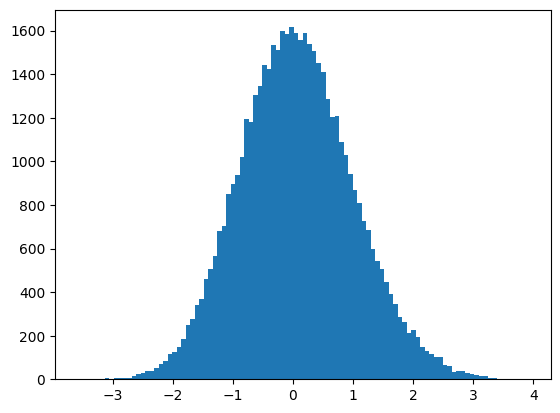

In [15]:
plt.hist(opt.bo_state.y[:50000].cpu().numpy(), bins=100)

In [16]:
print(opt.bo_state.y[:50000].max())

tensor(3.9184, device='cuda:1')


In [17]:
print(opt.bo_state.y[50000:].max())

tensor(3.7745, device='cuda:1')
